Training Double DQN...

--- Starting Training for DoubleDQN ---
DoubleDQN | Episode 1 | Reward: 10.0 | ε: 0.995
DoubleDQN | Episode 2 | Reward: 13.0 | ε: 0.990
DoubleDQN | Episode 3 | Reward: 12.0 | ε: 0.985
DoubleDQN | Episode 4 | Reward: 10.0 | ε: 0.980
DoubleDQN | Episode 5 | Reward: 11.0 | ε: 0.975
DoubleDQN | Episode 6 | Reward: 21.0 | ε: 0.970
DoubleDQN | Episode 7 | Reward: 15.0 | ε: 0.966
DoubleDQN | Episode 8 | Reward: 20.0 | ε: 0.961
DoubleDQN | Episode 9 | Reward: 25.0 | ε: 0.956
DoubleDQN | Episode 10 | Reward: 55.0 | ε: 0.951
DoubleDQN | Episode 11 | Reward: 27.0 | ε: 0.946
DoubleDQN | Episode 12 | Reward: 14.0 | ε: 0.942
DoubleDQN | Episode 13 | Reward: 23.0 | ε: 0.937
DoubleDQN | Episode 14 | Reward: 24.0 | ε: 0.932
DoubleDQN | Episode 15 | Reward: 17.0 | ε: 0.928
DoubleDQN | Episode 16 | Reward: 24.0 | ε: 0.923
DoubleDQN | Episode 17 | Reward: 38.0 | ε: 0.918
DoubleDQN | Episode 18 | Reward: 15.0 | ε: 0.914
DoubleDQN | Episode 19 | Reward: 16.0 | ε: 0.909
DoubleDQN | Ep

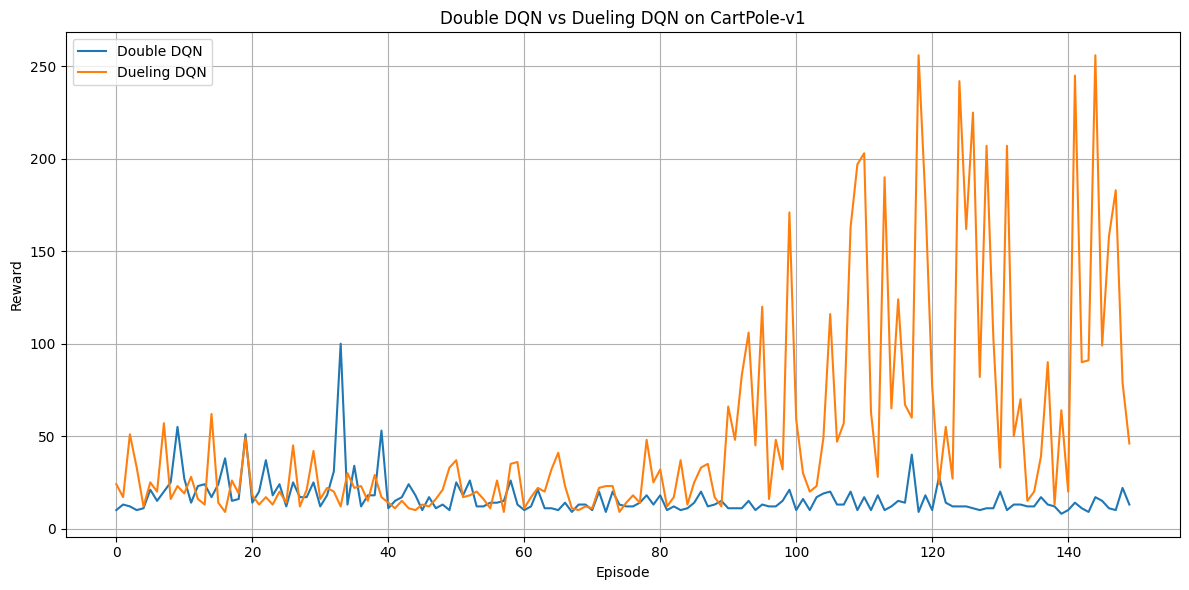


Pausing for 5 seconds before visualizing trained models...


In [1]:
import gym
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from collections import deque
import random
import warnings
import time
import os
from PIL import Image # For creating GIF from frames

# Fix numpy bool8 for older numpy versions
if not hasattr(np, 'bool8'):
    np.bool8 = np.bool_

warnings.filterwarnings('ignore')
tf.config.run_functions_eagerly(True)

# --- Hyperparameters ---
NUM_EPISODES = 150
BATCH_SIZE = 32
GAMMA = 0.99
BUFFER_SIZE = 10000
MIN_REPLAY_SIZE = 1000
EPSILON_START = 1.0
EPSILON_END = 0.01
EPSILON_DECAY = 0.995
TARGET_UPDATE_FREQ = 100
LEARNING_RATE = 1e-3
RENDER_DELAY = 0.02

# --- Environment ---
def make_env(render_mode='rgb_array'): # Always use rgb_array for frame capture
    return gym.make('CartPole-v1', render_mode=render_mode)

# Get state and action dimensions
env_test = make_env(render_mode='rgb_array')
num_actions = env_test.action_space.n
state_shape = env_test.observation_space.shape
env_test.close()

# --- Q-Networks ---
class DoubleDQN(tf.keras.Model):
    def __init__(self, num_actions):
        super().__init__()
        self.dense1 = layers.Dense(32, activation='relu', input_shape=state_shape)
        self.dense2 = layers.Dense(32, activation='relu')
        self.out = layers.Dense(num_actions)
        self(tf.ones((1,) + state_shape))  # Build model

    def call(self, x):
        x = self.dense1(x)
        x = self.dense2(x)
        return self.out(x)

class DuelingDQN(tf.keras.Model):
    def __init__(self, num_actions):
        super().__init__()
        self.dense1 = layers.Dense(32, activation='relu', input_shape=state_shape)
        self.dense2 = layers.Dense(32, activation='relu')
        self.V = layers.Dense(1)
        self.A = layers.Dense(num_actions)
        self(tf.ones((1,) + state_shape))  # Build model

    def call(self, x):
        x = self.dense1(x)
        x = self.dense2(x)
        V = self.V(x)
        A = self.A(x)
        return V + (A - tf.reduce_mean(A, axis=1, keepdims=True))

# --- Replay Buffer ---
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def add(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        return (
            np.array([x[0] for x in batch], dtype=np.float32),
            np.array([x[1] for x in batch], dtype=np.int32),
            np.array([x[2] for x in batch], dtype=np.float32),
            np.array([x[3] for x in batch], dtype=np.float32),
            np.array([x[4] for x in batch], dtype=np.bool8)
        )

    def __len__(self):
        return len(self.buffer)

# --- Training Function ---
def train_agent(agent_name, model_class, record_all_frames=False, gif_filename="training_animation.gif", episodes_to_record_full=[]):
    """
    Trains an RL agent and optionally records frames for a merged GIF.

    Args:
        agent_name (str): Name of the agent (e.g., "Double DQN").
        model_class (tf.keras.Model): The Q-network class (DoubleDQN or DuelingDQN).
        record_all_frames (bool): If True, records a frame from every step across all episodes
                                   for a single merged GIF. Be careful, this can create HUGE GIFs!
        gif_filename (str): Name of the output GIF file if record_all_frames is True.
        episodes_to_record_full (list): A list of specific episode numbers for which to record
                                        all frames for a merged GIF *after* training.
                                        This is usually better than record_all_frames.
    """
    env = make_env(render_mode='rgb_array') # Always use rgb_array for frame capture

    online_net = model_class(num_actions)
    target_net = model_class(num_actions)
    target_net.set_weights(online_net.get_weights())
    optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)
    loss_fn = tf.keras.losses.Huber()
    buffer = ReplayBuffer(BUFFER_SIZE)
    epsilon = EPSILON_START
    rewards_history = []

    all_frames = [] # To store frames for the merged GIF

    print(f"\n--- Starting Training for {agent_name} ---")

    for episode in range(1, NUM_EPISODES + 1):
        reset_result = env.reset()
        state = reset_result[0] if isinstance(reset_result, tuple) else reset_result
        episode_reward = 0
        done = False

        # Determine if this episode's frames should be recorded for the merged GIF
        capture_frames_for_current_episode = (record_all_frames or (episode in episodes_to_record_full))

        # If we are recording for a merged GIF, capture the initial frame
        if capture_frames_for_current_episode:
             frame = env.render() # Capture the initial frame
             if frame is not None:
                 # Squeeze potentially extra dimensions
                 all_frames.append(Image.fromarray(np.squeeze(np.asarray(frame)))) # MODIFIED LINE
             else:
                 print(f"Warning: env.render() returned None for initial frame in episode {episode}.")

        while not done:
            # Add a small delay for visualization if not capturing all frames, to make it human-readable
            if not capture_frames_for_current_episode:
                # env.render() # You can uncomment this if you still want to see the live human view
                time.sleep(RENDER_DELAY)

            # ε-greedy action
            if random.random() < epsilon:
                action = env.action_space.sample()
            else:
                q_values = online_net(tf.expand_dims(state, 0))[0]
                action = int(tf.argmax(q_values).numpy())

            step_result = env.step(action)
            if len(step_result) == 5:
                next_state, reward, terminated, truncated, _ = step_result
                done = terminated or truncated
            else:
                next_state, reward, done, _ = step_result

            episode_reward += reward
            buffer.add(state, action, reward, next_state, done)
            state = next_state

            # Capture frame if required
            if capture_frames_for_current_episode:
                frame = env.render()
                if frame is not None:
                    # Squeeze potentially extra dimensions
                    all_frames.append(Image.fromarray(np.squeeze(np.asarray(frame)))) # MODIFIED LINE
                else:
                    # This warning might spam if render() consistently returns None
                    # print(f"Warning: env.render() returned None for step in episode {episode}.")
                    pass

            if len(buffer) >= MIN_REPLAY_SIZE:
                states, actions, rewards_batch, next_states, dones = buffer.sample(BATCH_SIZE)

                with tf.GradientTape() as tape:
                    next_q = online_net(next_states)
                    best_actions = tf.argmax(next_q, axis=1)
                    indices = tf.stack([
                        tf.range(BATCH_SIZE, dtype=tf.int32),
                        tf.cast(best_actions, tf.int32)
                    ], axis=1)
                    target_q = tf.gather_nd(target_net(next_states), indices)
                    targets = rewards_batch + (1 - tf.cast(dones, tf.float32)) * GAMMA * target_q

                    q_values = online_net(states)
                    current_q = tf.reduce_sum(q_values * tf.one_hot(actions, num_actions), axis=1)
                    loss = loss_fn(targets, current_q)

                grads = tape.gradient(loss, online_net.trainable_variables)
                optimizer.apply_gradients(zip(grads, online_net.trainable_variables))

            if len(buffer) % TARGET_UPDATE_FREQ == 0:
                target_net.set_weights(online_net.get_weights())

        epsilon = max(EPSILON_END, epsilon * EPSILON_DECAY)
        rewards_history.append(episode_reward)
        print(f"{agent_name} | Episode {episode} | Reward: {episode_reward:.1f} | ε: {epsilon:.3f}")

    env.close()

    if record_all_frames or episodes_to_record_full:
        print(f"Creating merged GIF for {agent_name}...")
        if all_frames: # Ensure there are frames to save
            # Create a directory for GIFs if it doesn't exist
            gif_dir = "./merged_gifs"
            os.makedirs(gif_dir, exist_ok=True)

            output_path = os.path.join(gif_dir, gif_filename)

            # Ensure the first frame is explicitly a PIL Image before saving
            # This defensive conversion should now include squeezing
            if not isinstance(all_frames[0], Image.Image):
                 all_frames[0] = Image.fromarray(np.squeeze(np.asarray(all_frames[0])))

            all_frames[0].save(
                output_path,
                save_all=True,
                append_images=all_frames[1:],
                optimize=False,
                duration=50,    # Duration between frames in milliseconds (e.g., 50ms = 20fps)
                loop=0          # Loop forever (0)
            )
            print(f"Merged GIF saved to {output_path}")
        else:
            print(f"No frames were captured for {agent_name} to create a GIF.")

    return rewards_history, online_net # Return the trained model

# --- Main Execution ---
if __name__ == '__main__':
    print("Training Double DQN...")
    double_rewards, double_dqn_model = train_agent(
        "DoubleDQN", DoubleDQN,
        record_all_frames=False,
        episodes_to_record_full=[1, 20, 49,100,150], # Record frames for these episodes
        gif_filename="DoubleDQN_selected_episodes_training.gif"
    )

    print("\nTraining Dueling DQN...")
    dueling_rewards, dueling_dqn_model = train_agent(
        "DuelingDQN", DuelingDQN,
        record_all_frames=False,
        episodes_to_record_full=[1, 20, 49,100,150], # Record frames for these episodes
        gif_filename="DuelingDQN_selected_episodes_training.gif"
    )

    # --- Optional: Visualize a trained model's performance ---
    # This is a separate run *after* training to show the final policy's performance
    def visualize_trained_model(agent_name, model, num_episodes=1, gif_filename="trained_model_performance.gif", fps=30):
        print(f"\nVisualizing trained {agent_name} for {num_episodes} episode(s)...")
        env = make_env(render_mode='rgb_array')
        frames = []
        for i in range(num_episodes):
            state = env.reset()[0]
            done = False
            while not done:
                frame = env.render()
                if frame is not None:
                    # Squeeze potentially extra dimensions
                    frames.append(Image.fromarray(np.squeeze(np.asarray(frame)))) # MODIFIED LINE

                q_values = model(tf.expand_dims(state, 0))[0]
                action = int(tf.argmax(q_values).numpy())

                step_result = env.step(action)
                if len(step_result) == 5:
                    next_state, reward, terminated, truncated, _ = step_result
                    done = terminated or truncated
                else:
                    next_state, reward, done, _ = step_result
                state = next_state
        env.close()

        if frames:
            gif_dir = "./merged_gifs"
            os.makedirs(gif_dir, exist_ok=True)
            output_path = os.path.join(gif_dir, gif_filename)
            duration_ms = 1000 / fps
            # Ensure the first frame is explicitly a PIL Image before saving
            # This defensive conversion should now include squeezing
            if not isinstance(frames[0], Image.Image):
                 frames[0] = Image.fromarray(np.squeeze(np.asarray(frames[0])))
            frames[0].save(
                output_path,
                save_all=True,
                append_images=frames[1:],
                optimize=False,
                duration=duration_ms,
                loop=0
            )
            print(f"Trained model performance GIF saved to {output_path}")
        else:
            print("No frames captured for trained model visualization.")

    # --- Plot Results ---
    plt.figure(figsize=(12, 6))
    plt.plot(double_rewards, label="Double DQN")
    plt.plot(dueling_rewards, label="Dueling DQN")
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.title("Double DQN vs Dueling DQN on CartPole-v1")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("cartpole_comparison.png")
    plt.show()

    # --- Add a small delay here before visualizing ---
    print("\nPausing for 5 seconds before visualizing trained models...")
    time.sleep(5) # Give the previous environment some time to clean up

    # Now uncomment these lines
    #visualize_trained_model("DoubleDQN_Final", double_dqn_model, num_episodes=1, gif_filename="DoubleDQN_final_performance.gif")
    #visualize_trained_model("DuelingDQN_Final", dueling_dqn_model, num_episodes=1, gif_filename="DuelingDQN_final_performance.gif")
